# pulse_input_DDM choice model tutorial

This is a pretty detailed, but not exahaustive crash course in using this code to fit the classic "Bing's model" to choice data. Things you can learn:

- How to make fake data
- How to fit the model
- How to generate confidence intervals
- How to deal with non-invertible Hessians

Other things this notebook shows:

- Multiple initialzations converge to the same solution
- The model can recover the generative parameters from fake data
- The model can recover more than 1 set of parameters
- Fits get better with more data
- Sometimes the model can get stuck at a saddle point

`using` is the julia version of python's `import`, i.e. in incorporates the exported functions of a module into the current namespace. `Distributed` is a julia module for performing parallel computing. `addprocs()` adds some workers, which can be called by a main process if there are calls to do things in parallel. `pulse_input_DDM` parallelizes the computation of the log-likelhood across trials.

In [ ]:
using Distributed
addprocs(44);

Worker 2 terminated.


when `using` is called after workers have been made, i.e. above, then those modules are available on all the workers (i.e. any function called from those modules will be able to be executed on any worker)

In [2]:
using pulse_input_DDM, Flatten

┌ Info: Recompiling stale cache file /usr/people/briandd/.julia/compiled/v1.2/pulse_input_DDM/m8WoA.ji for pulse_input_DDM [c2542da2-1f7d-11e9-2506-87691095ebb2]
└ @ Base loading.jl:1240


create some parameters to generate data with

In [3]:
θ_generative = θchoice(θz=θz(σ2_i = 5., B = 8., λ = -1., σ2_a = 20., σ2_s = 0.5,
    ϕ = 0.8, τ_ϕ = 0.05), bias=2., lapse=0.05);

"flatten" them into a vector for easy use later

In [4]:
x_generative = collect(Flatten.flatten(θ_generative));

`pulse_input_DDM` computes the log-likelihood by propogating mass of the latent distribution in time. This is done numerically by dividing the distribution up into little temporal and spatial bins. `n` is the number of spatials bins to use. `n=53` seems to work well.

In [5]:
n = 53

53

## Fit 20K trials

Generate some fake data using the above parameters, and then see if you can recover it from a few different initializations of the optimization

Define bounds for each parameter for the optimization. Some of these are strict (i.e. variance > 0) and some are not (B < 100 seems reasonable, but B could of course be larger then 100.)

In [6]:
lb = [0., 2.,  -5., 0.,   0.,  0., 0.005, -5.0, 0.0]
ub = [30., 100., 5., 200., 10., 1.2,  1., 5.0, 1.0];

generate 20K trials of fake data. change `rng` to get a different set with the same parameters. `dt` specifies the temporal binning of the data. `1e-2` has worked well.

In [7]:
_, data_20K = synthetic_data(n ;θ=θ_generative, ntrials=20_000, rng=1, dt=1e-2);

`fit` specifies which parameters should be learned. If they are not learned, they remain at their value from `x0`, the initial point of the optimization.

In [8]:
fit = vcat(trues(9));
x0 = vcat([0.1, 15., -0.1, 20.,  0.5, 0.2,  0.008], [0.,  0.01]);

wrap up the generative parameters and the data into the `choiceDDM` class

In [9]:
model = choiceDDM(θ=θ_generative, data=data_20K, n=n)

choiceDDM{θchoice{θz{Float64},Float64},Array{pulse_input_DDM.choicedata{pulse_input_DDM.choiceinputs{pulse_input_DDM.clicks,pulse_input_DDM.binned_clicks}},1}}
  θ: θchoice{θz{Float64},Float64}
  data: Array{pulse_input_DDM.choicedata{pulse_input_DDM.choiceinputs{pulse_input_DDM.clicks,pulse_input_DDM.binned_clicks}}}((20000,))
  n: Int64 53
  cross: Bool false


to see the docstring for `choiceDDM` type `?`

In [10]:
? choiceDDM

search: choiceDDM load_choice_data save_choice_model reload_choice_model



```
choiceDDM(θ, data, n, cross)
```

Fields:

  * `θ`: a instance of the module-defined class `θchoice` that contains all of the model parameters for a `choiceDDM`
  * `data`: an `array` where each entry is the module-defined class `choicedata`, which contains all of the data (inputs and choices).
  * `n`: number of spatial bins to use (defaults to 53).
  * `cross`: whether or not to use cross click adaptation (defaults to false).

Example:

```julia
ntrials, dt, centered, n  = 1, 1e-2, false, 53
θ = θchoice()
_, data = synthetic_data(n ;θ=θ, ntrials=ntrials, rng=1, dt=dt);
choiceDDM(θ=θ, data=data, n=n)
```


compute the log-likelihood of the generative data. results from optimization should be larger than this

In [11]:
loglikelihood(model)

-6232.528137192193

In [12]:
? choiceoptions

search: choiceoptions



```
choiceoptions(fit, lb, ub)
```

Fields:

  * `fit`: `array` of `Bool` for optimization for `choiceDDM` model.
  * `lb`: `array` of lower bounds for optimization for `choiceDDM` model.
  * `ub`: `array` of upper bounds for optimization for `choiceDDM` model.


In [13]:
options = choiceoptions(fit=fit, lb=lb, ub=ub)

choiceoptions
  fit: Array{Bool}((9,)) Bool[1, 1, 1, 1, 1, 1, 1, 1, 1]
  lb: Array{Float64}((9,)) [0.0, 2.0, -5.0, 0.0, 0.0, 0.0, 0.005, -5.0, 0.0]
  ub: Array{Float64}((9,)) [30.0, 100.0, 5.0, 200.0, 10.0, 1.2, 1.0, 5.0, 1.0]


example of how to optimize parameters given data

In [15]:
? optimize

search: optimize



```
optimize(x, ll, lb, ub)
```

Wrapper for executing an constrained optimization.

Arguments:

  * `ll`: objective function.
  * `x`: an `array` of initial point
  * `lb`: lower bounds. `array` the same length as `x`.
  * `ub: upper bounds.`array`the same length as`x`.

---

```
optimize(data, options)
```

Optimize model parameters for a `choiceDDM`.

Returns:

  * `model`: an instance of a `choiceDDM`.
  * `output`: results from [`Optim.optimize`](@ref).

Arguments:

  * `data`: an `array`, each element of which is a module-defined type `choicedata`. `choicedata` contains the click data and the choice for a trial.
  * `options`: module-defind type that contains the upper (`ub`) and lower (`lb`) boundaries and specification of which parameters to fit (`fit`).

---

```
optimize(data, f)
```

Optimize model parameters for a `neuralDDM`. Neural tuning parameters ([`θy`](@ref)) are initialized by fitting a the noiseless DDM model first ([`noiseless_neuralDDM`](@ref)).

Arguments:

  * `data`: the output of [`load_neural_data`](@ref) with the format as described in its docstring.
  * `f`: an `array` of length number of sessions, where each subarray is length number of cells. Each entry is a string, either `Softplus` or `Sigmoid` to describe the nonlinear map between $a(t)$ and $\lambda(a)$, the expected firing rate.

Returns

  * `model`: a module-defined type that organizes the `data` and parameters from the fit (as well as a few other things that are necessary for re-computing things the way they were computed here (e.g. `n`)
  * `options`: some details related to the optimzation, such as which parameters were fit, and the upper and lower bounds of those parameters.

---

```
optimize(model, options)
```

Optimize model parameters for a `neuralDDM`.

Arguments: 

  * `model`: an instance of a `neuralDDM`.
  * `options`: some details related to the optimzation, such as which parameters were fit (`fit`), and the upper (`ub`) and lower (`lb`) bounds of those parameters.

Returns:

  * `model`: an instance of a `neuralDDM`.
  * `output`: results from [`Optim.optimize`](@ref).

---

```
optimize(model, options)
```

Optimize model parameters for a `noiseless_neuralDDM`.

Arguments: 

  * `model`: an instance of a `noiseless_neuralDDM`.
  * `options`: some details related to the optimzation, such as which parameters were fit (`fit`), and the upper (`ub`) and lower (`lb`) bounds of those parameters.

Returns:

  * `model`: an instance of a `noiseless_neuralDDM`.
  * `output`: results from [`Optim.optimize`](@ref).


In [16]:
model, = optimize(data_20K, options; x0=x0)

Fminbox
-------
Initial mu = 0.287565

Fminbox iteration 1
-------------------
Calling inner optimizer with mu = 0.287565

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     7.358249e+03     9.959929e+04
 * time: 7.295608520507812e-5
    10     6.235841e+03     1.997309e+03
 * time: 222.64303493499756
    20     6.228355e+03     1.870122e+02
 * time: 388.0493149757385
    30     6.224339e+03     2.129872e+02
 * time: 589.5150079727173
    40     6.221577e+03     1.253825e+02
 * time: 831.9417400360107
    50     6.221040e+03     1.995144e+01
 * time: 992.4752130508423
    60     6.221033e+03     1.954376e-01
 * time: 1162.337998867035

Exiting inner optimizer with x = [10.916620533314346, 8.111665694950315, -1.0172586942859263, 23.375776579232554, 0.3194059262214294, 0.7472175727631757, 0.04078542983369815, 2.0899029043470105, 0.02497039758295109]
Current distance to box: 0.0249704
Decreasing barrier term μ.

Fminbox iteration 2
-----------

(choiceDDM{θchoice{θz{Float64},Float64},Array{pulse_input_DDM.choicedata{pulse_input_DDM.choiceinputs{pulse_input_DDM.clicks,pulse_input_DDM.binned_clicks}},1}}
  θ: θchoice{θz{Float64},Float64}
  data: Array{pulse_input_DDM.choicedata{pulse_input_DDM.choiceinputs{pulse_input_DDM.clicks,pulse_input_DDM.binned_clicks}}}((20000,))
  n: Int64 53
  cross: Bool false
,  * Status: success

 * Candidate solution
    Minimizer: [1.20e+01, 8.10e+00, -1.01e+00,  ...]
    Minimum:   6.226498e+03

 * Found with
    Algorithm:     Fminbox with BFGS
    Initial Point: [1.00e-01, 1.50e+01, -1.00e-01,  ...]

 * Convergence measures
    |x - x'|               = 2.51e-06 ≰ 1.0e-10
    |x - x'|/|x'|          = 8.97e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.03e-07 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.27e-11 ≤ 1.0e-09
    |g(x)|                 = 5.01e-02 ≰ 1.0e-03

 * Work counters
    Seconds run:   1889  (vs limit 170000)
    Iterations:    3
    f(x) calls:    729
    ∇f(x) calls:   236
)

In [19]:
using Random

define a function for generating an `x0` and then fitting the model. this is done just so I can fit the model mutliply times. 

If you just wanted to fit it once, you need to specify `choiceoptions`, which is the parameters to fit (`fit`), the bounds (`lb` and `ub`) and the initial point (`x0`). then call the `optimize` function with the `data` and the `options`. there are some optional parameters too, like tolerances, etc.

In [20]:
function fit_x0(rng, fit, x0, lb, ub, data)

    Random.seed!(rng)
    x00 = lb + (ub - lb) .* rand(length(x0))
    x00[2] = 15.
    options = choiceoptions(fit=fit, lb=lb, ub=ub)
    model, output = optimize(data, options; x0=x00, f_tol=1e-9, extended_trace=true, show_trace=true)
    
end

fit_x0 (generic function with 1 method)

fit the model and then gather the values of the optimization at each iteration for more easy use.

In [21]:
output = map(rng-> fit_x0(rng, fit, x0, lb, ub, data_20K), 1:3)
traces = map(y-> hcat(map(x-> x.metadata["x"], y[2].trace)...), output)

Fminbox
-------
Initial mu = 0.0258827

Fminbox iteration 1
-------------------
Calling inner optimizer with mu = 0.0258827

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     1.892323e+04     2.401371e+04
 * Current step size: 1.0
 * time: 7.295608520507812e-5
 * g(x): [-45.58319281741931, -45.19493132404622, -802.3906401183569, -101.69631158340064, -177.0825933248963, -1199.445618424235, 956.3128834200883, 717.721719883081, -24013.71066163247]
 * ~inv(H): [1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0]
 * x: [7.081000369861408, 15.0, -1.8729303166393252, 1.581856678112148, 4.886128300795011, 0.25316184259024316, 0.9521567581365553, 4.999046588986136, 0.25166

    50     6.233878e+03     1.662952e+01
 * Current step size: 1.0
 * time: 941.420725107193
 * g(x): [0.137621520576177, -0.5223496807656108, 1.6390857860433443, -1.0947600603359746, 4.48538338520929, 1.7635341068224897, -15.410957869298958, -2.1645175696077894, 16.629515051426594]
 * ~inv(H): [7.642465006724764 1.0352962193403195 0.3388783091403012 0.2779170980725674 -0.1396302629924634 -0.04488175405523827 -0.009363943235188707 0.1435266022835986 -0.0065175730046799964; 1.0352962193403177 0.5842146584637993 0.1722325195596019 0.043270870896576344 0.0275455834137329 0.006728013675632081 -0.0009964011612565496 0.10609469317161006 0.0004006298689428184; 0.33887830914030137 0.17223251955960198 0.07286872371789209 0.007331593224392401 0.0017229477116730183 0.0025515194159591147 1.0894994928278718e-5 0.035690656996372035 0.00019197447045285089; 0.2779170980725675 0.04327087089657633 0.007331593224392403 0.18592559772555808 -0.002182886184481035 0.0015996469389514152 0.00011512962252573394


Exiting inner optimizer with x = [11.861253291886912, 8.098394171433242, -1.0148835061395587, 23.750743310018642, 0.2862975277590108, 0.7471227371964285, 0.041101367588181746, 2.0789541532794362, 0.018844129139453387]
Current distance to box: 0.0188441
Decreasing barrier term μ.

Fminbox iteration 2
-------------------
Calling inner optimizer with mu = 2.58827e-5

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     6.226498e+03     9.508696e-01
 * Current step size: 1.0
 * time: 4.506111145019531e-5
 * g(x): [-0.0018848219760589078, 0.011122451163689522, -0.0004842338584990274, 0.0009266360355561789, 0.09599077521658023, -0.0112953711476365, 0.5655875140514524, -0.003031291923454964, 0.9508695878286012]
 * ~inv(H): [1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0; 0.0 0.

    40     6.231406e+03     8.798808e+01
 * Current step size: 1.0
 * time: 753.0219569206238
 * g(x): [-0.8058241554749745, 0.18896848510568687, -1.462971939872642, 0.2113597382108609, -8.817388755710656, 28.329675850025595, -50.43419492905052, -0.1834416078058837, -87.98807578686802]
 * ~inv(H): [0.060657157723208566 0.03834333561592532 0.003744957782960162 -0.5279266457529284 0.0006498470392186433 0.00020546005444385885 0.0001989867047036743 -0.003131074895439836 0.0002912622032884883; 0.03834333561592543 0.7511686880884219 0.04483100043218423 -0.24532795390248724 -0.00021598949218799358 9.427774237900414e-5 -0.00033813001151703295 0.024775065309403002 0.0001427119060603038; 0.0037449577829601695 0.04483100043218422 0.01503621341694282 -0.17928624666384352 0.00027083883768596326 0.00024563506086630816 0.00015046828142708716 0.004761095898028231 -3.729666764447614e-5; -0.5279266457529277 -0.24532795390248846 -0.17928624666384355 24.24956220493954 -0.032510712163049744 0.0066673571143

    80     6.221528e+03     9.572089e+01
 * Current step size: 1.0
 * time: 1695.7576670646667
 * g(x): [0.22422444718460494, -1.1258069797055923, 1.3661362028989803, 0.2745046417815327, 8.002210715680153, -12.15980516088378, 95.72089133116438, -0.6348688554076524, 38.39744244008903]
 * ~inv(H): [5.347829253083809 0.12921819389141584 -0.06388478739597475 -5.076530309269995 0.0720963088221662 0.03674025079084652 0.0022983709551887437 0.0795034879558951 -0.02257565008654632; 0.12921819389141542 0.188234195774097 0.0204884224973339 0.11241674442445604 0.02197589403389608 0.0024177235451397928 -0.0006527842827604845 0.03605174383444025 0.000942222769633929; -0.06388478739597472 0.020488422497333778 0.030221065030577608 0.06785188869468087 -0.007058286232511122 0.0010505723299105998 0.00040563379387583207 0.006335306367129424 0.00034367215085297003; -5.076530309269996 0.11241674442445582 0.06785188869468087 6.7987857518003025 -0.09345045756219547 -0.04137311490327676 -0.003975517626351682 -


Exiting inner optimizer with x = [12.042686044468443, 8.098694617969452, -1.0138642881738686, 23.811311357672896, 0.2808324206501237, 0.7472707666442509, 0.04116715416570049, 2.0776265825980285, 0.01766821902064717]
Current distance to box: 0.0176682
Decreasing barrier term μ.

Fminbox iteration 3
-------------------
Calling inner optimizer with mu = 2.75304e-7

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     6.226498e+03     1.397781e-01
 * Current step size: 1.0
 * time: 0.00010013580322265625
 * g(x): [0.0004187103442093593, -0.0031331755753490034, -0.0013126731843222923, -0.0001371680856876482, -0.008386641862630117, 0.06685626412481571, -0.13977811998560463, 0.001827489462790229, 0.0730525259341586]
 * ~inv(H): [1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0; 0

    40     6.385260e+03     1.607969e+03
 * Current step size: 1.0
 * time: 685.9339461326599
 * g(x): [6.860456848674724, -41.0236426510043, 90.64248634644375, 2.847251442508049, 78.96542449807275, -1607.9694408769917, 467.33436305005324, -4.3481351377440935, 1448.9085263975385]
 * ~inv(H): [0.00767727675106448 0.002880439439700678 -0.0009385868982904518 0.21803125830739334 -0.0059754774280435345 -3.913001967700899e-5 -3.747505557105375e-7 -0.002863337896920044 -2.7438960674572812e-6; 0.0028804394397006572 0.09256284249620325 -0.0023835869522678965 1.6421316098871261 -0.015870846711993847 0.0001118090875181688 0.00027173126221734505 -0.000948060098388508 -1.222417378462334e-6; -0.0009385868982904683 -0.0023835869522679277 0.014735197647935414 -0.7384884844504058 0.0006196082893428559 -5.7419310503265935e-5 1.9600602004520793e-5 0.007713984992302841 9.352687831427768e-6; 0.21803125830739323 1.6421316098871248 -0.7384884844504056 94.91468232771825 -1.0263221760359422 0.00474643820265337

    80     6.235576e+03     2.317513e+03
 * Current step size: 1.0
 * time: 1398.3132750988007
 * g(x): [0.4257005260381387, -0.8656324227037343, -0.5402560660361788, -0.7322380555504904, 1.1604745721828158, -20.711345901782856, 92.44858722245583, 1.1583736208499549, -2317.5128299612165]
 * ~inv(H): [0.07998409432295685 0.029915382691699122 0.010053417686061526 -0.10478159168903518 0.006795263301478423 0.009477206286555231 0.001342893207211013 0.010249865546638176 -3.1439140360138907e-6; 0.029915382691699095 0.03458044528974602 0.007502937942203475 -0.04832699266440757 0.007859809658288693 0.0042353884691193845 0.000473137715195852 0.011537743083784307 -1.3169907778106746e-6; 0.010053417686061508 0.00750293794220346 0.0279279251765895 -0.01709828693166638 -0.01029230044129184 0.001279598172179759 0.0003372409317212889 0.015548856438395745 -4.6812988251580796e-7; -0.10478159168903524 -0.048326992664409735 -0.017098286931666068 0.16435971065406543 -0.01627201585606957 -0.0142097208480969

   120     6.225977e+03     4.995262e+01
 * Current step size: 0.016277921294750006
 * time: 2267.8319160938263
 * g(x): [0.33325110256655827, -1.1830856198112745, 2.312465707876181, 0.14350841135531894, 1.8503575336278537, 7.830106518339664, -49.952623756618664, -2.0469984020574556, 10.50185074523452]
 * ~inv(H): [1.0364453190581255 -0.08225466462125133 0.18627175193429166 0.010346196474907912 -0.08630032948500987 0.013956615975918105 0.005426315775860131 -0.19066689738130038 -0.008973769883557968; -0.08225466462125135 1.1805803742796748 -0.4082260202998314 -0.021962941320652404 0.26454892722792434 -0.034434957761316894 -0.01566794158549968 0.43167467495741113 0.02934504248346643; 0.18627175193429168 -0.4082260202998314 1.918449186750674 0.04955027237745365 -0.6107400539194339 0.12942857014793058 0.0436045703624283 -0.9772446193891781 -0.027612720629396008; 0.010346196474907912 -0.0219629413206524 0.04955027237745365 1.0025330074115488 -0.044261450178164935 0.0018470643110723886 0.001

    20     6.226497e+03     1.255654e-01
 * Current step size: 1.0
 * time: 462.12502002716064
 * g(x): [0.00014871863409419178, 0.005055856219307813, 0.0017960622826812373, -0.0003351009813173021, 0.005872452685256493, -0.043129291935429984, 0.12556539557723786, -0.0015066350482524217, 0.01848884773194533]
 * ~inv(H): [28.93680705199244 2.750860626015892 0.651634317521097 -2.8615833593898934 -0.17804480162500264 0.09079634514248021 0.002910956484426708 0.4445270547064488 -0.12675521477660032; 2.7508606260158928 0.5664593474968841 0.15460627255081572 0.12406019310158123 -0.008721383419008417 0.008623123413350987 -0.0005754968696275622 0.08808394048262885 -0.005978461720583827; 0.651634317521097 0.15460627255081655 0.07736788131358864 -0.030806615939836468 -0.009131957604328566 0.003591232989420925 0.00031757942719940906 0.0286175345055561 -0.0010339998151998266; -2.861583359389879 0.1240601931015819 -0.03080661593983669 24.181375350264975 -0.5038916455297753 -0.03174031176372723 -0.001

3-element Array{Array{Float64,2},1}:
 [7.081000369861408 7.0823914585094006 … 11.861253297387316 11.861253351629479; 15.0 15.001379239847536 … 8.098394138975015 8.09839391666511; … ; 4.999046588986136 4.977143460327595 … 2.07895416212554 2.0789542836915658; 0.25166218303197185 0.9845024742194862 … 0.018841354252964116 0.018830786102722638]  
 [11.00389237319773 11.003888075002779 … 12.042686043667228 12.042686033982934; 15.0 14.997971533773242 … 8.098694623964878 8.098694675676885; … ; -0.8413043188939673 -0.7895677814227063 … 2.0776265791010724 2.0776265254361577; 0.54015152302257 0.3898431501979416 … 0.017668079232435057 0.0176665566318662]
 [24.350952149875845 24.35092650245421 … 12.040085474053425 12.040085477477456; 15.0 15.000025136352042 … 8.099123000664237 8.099122967512871; … ; -4.9574203939948465 -4.957315699064278 … 2.07763474786608 2.077634786322515; 0.9746379934512355 0.8455973751682172 … 0.01768972880920907 0.017690097174840123] 

In [22]:
models_20K = map(y-> y[1], output)

3-element Array{choiceDDM{θchoice{θz{Float64},Float64},Array{pulse_input_DDM.choicedata{pulse_input_DDM.choiceinputs{pulse_input_DDM.clicks,pulse_input_DDM.binned_clicks}},1}},1}:
 choiceDDM{θchoice{θz{Float64},Float64},Array{pulse_input_DDM.choicedata{pulse_input_DDM.choiceinputs{pulse_input_DDM.clicks,pulse_input_DDM.binned_clicks}},1}}
  θ: θchoice{θz{Float64},Float64}
  data: Array{pulse_input_DDM.choicedata{pulse_input_DDM.choiceinputs{pulse_input_DDM.clicks,pulse_input_DDM.binned_clicks}}}((20000,))
  n: Int64 53
  cross: Bool false

 choiceDDM{θchoice{θz{Float64},Float64},Array{pulse_input_DDM.choicedata{pulse_input_DDM.choiceinputs{pulse_input_DDM.clicks,pulse_input_DDM.binned_clicks}},1}}
  θ: θchoice{θz{Float64},Float64}
  data: Array{pulse_input_DDM.choicedata{pulse_input_DDM.choiceinputs{pulse_input_DDM.clicks,pulse_input_DDM.binned_clicks}}}((20000,))
  n: Int64 53
  cross: Bool false

 choiceDDM{θchoice{θz{Float64},Float64},Array{pulse_input_DDM.choicedata{pulse_input_DDM

compute the hessian around the maximum likehood solution for each fit model (there's 3, for 3 initializations)

In [23]:
H_20K = map(x-> Hessian(x), models_20K);

In [24]:
using LinearAlgebra

take a look at the eigenvalues of each hessian. all eigenvalues should be greater than 0.

In [25]:
eigvals.(H_20K)

3-element Array{Array{Float64,1},1}:
 [0.023164354252375053, 0.03744440874071347, 1.8729224483798121, 22.057474893736597, 59.16531226115367, 503.7578585326969, 798.5609000032173, 77747.37621292494, 720227.8232769242]
 [0.02251022770261459, 0.03646163346180113, 1.892611716244287, 22.079946514006302, 59.23380099190506, 504.6882002575916, 800.4775432600823, 77541.81150514148, 720446.0360570108]  
 [0.0224645307451125, 0.03645120245699947, 1.8909170228963899, 22.081035529111485, 59.22246534190007, 504.5919277611789, 800.2102597543324, 77544.08872069379, 720657.6359441672]  

Compute confidence bounds on the parameter estimates using the laplace approximation

In [26]:
CIs = map(H -> 2 * sqrt.(diag(inv(H))), H_20K)

3-element Array{Array{Float64,1},1}:
 [11.440019926916285, 1.8401542157909772, 0.6231790616517551, 12.121469595298832, 0.40086952217819244, 0.0829070173717489, 0.013828073037986768, 0.3900934233142095, 0.05707233881998356]   
 [11.743939626720035, 1.8522193691360649, 0.6244604582155179, 12.153668812854551, 0.40155346926717306, 0.08291244574479245, 0.013831273931503863, 0.39016629656197965, 0.059304938999041414]
 [11.752096774766786, 1.8546929461499597, 0.6248438294101536, 12.161620683537157, 0.4017297645142498, 0.08292191131375312, 0.013830042260375137, 0.390111212732516, 0.059319541241370836]   

In [27]:
x_fit_20K = map(x-> collect(Flatten.flatten(x.θ)), models_20K)

3-element Array{Array{Float64,1},1}:
 [11.861253351629479, 8.09839391666511, -1.0148835015760937, 23.75074330092777, 0.28629615168020256, 0.7471212097417715, 0.04110268146768398, 2.0789542836915658, 0.018830786102722638]
 [12.042686033982934, 8.098694675676885, -1.013864254076618, 23.811311359779697, 0.2808325833822111, 0.7472698029766948, 0.0411674128589897, 2.0776265254361577, 0.0176665566318662]   
 [12.040085477477456, 8.099122967512871, -1.0137966508594538, 23.81614428490442, 0.28082081660363395, 0.7472361019855284, 0.04116092342093653, 2.077634786322515, 0.017690097174840123]

In [28]:
using PyPlot

plot the parameters at each iteration of the optimization, the final values and their confidence intervals

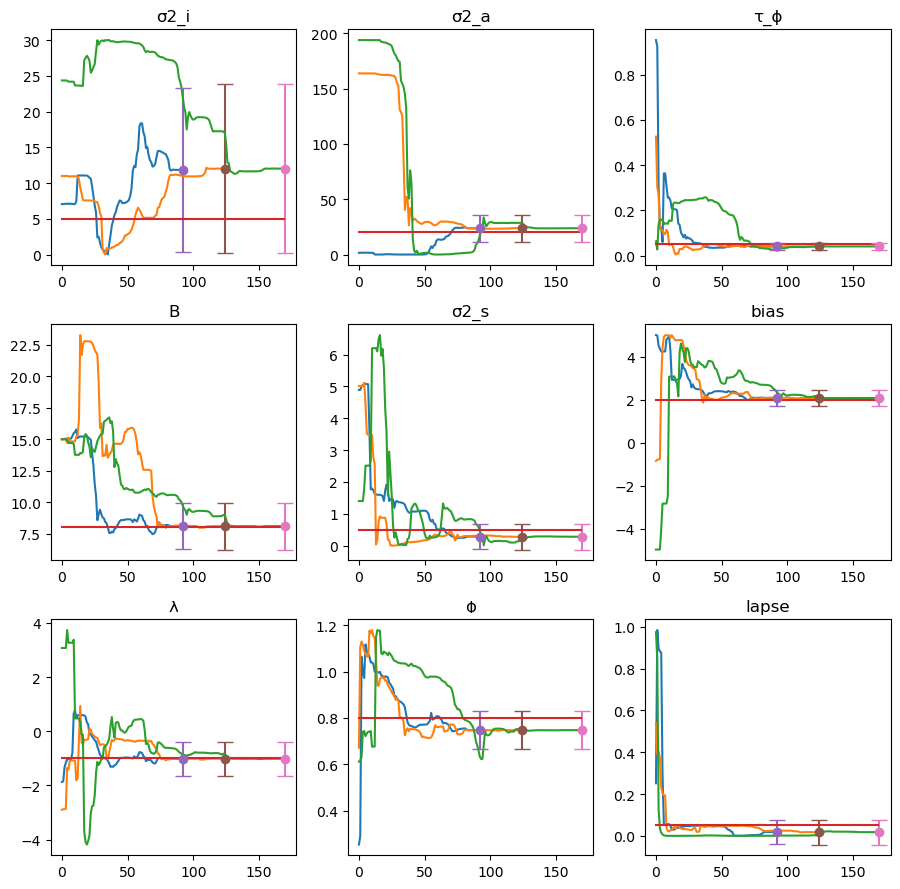

In [29]:
num_rows, num_cols = 3,3
fig, ax = subplots(num_rows, num_cols, figsize=(9,9))
name = ["σ2_i", "B", "λ", "σ2_a", "σ2_s", "ϕ", "τ_ϕ", "bias", "lapse"]

for i in 1:9
                  
    map(x-> ax[i].plot(x[i,:]), traces[1:3])
    ax[i].plot(collect(Flatten.flatten(θ_generative))[i] * ones(maximum(length.(map(x-> x[i,:], traces[1:3])))))
    ax[i].set_title(name[i])
    
    ax[i].errorbar(size(traces[1], 2), x_fit_20K[1][i], yerr=CIs[1][i], fmt="o",
        capsize=6)
    ax[i].errorbar(size(traces[2], 2), x_fit_20K[2][i], yerr=CIs[2][i], fmt="o",
        capsize=6)
    ax[i].errorbar(size(traces[3], 2), x_fit_20K[3][i], yerr=CIs[3][i], fmt="o",
        capsize=6)
end

tight_layout() 

In [30]:
CIs_20K = map((x,H) -> hcat(collect(Flatten.flatten(x.θ)) - 2 * sqrt.(diag(inv(H))), 
    collect(Flatten.flatten(x.θ)),
    collect(Flatten.flatten(x.θ)) + 2 * sqrt.(diag(inv(H)))), models_20K, H_20K);

In [31]:
map(i-> all((CIs_20K[i][:,1] .< collect(Flatten.flatten(θ_generative))) 
        .&(CIs_20K[i][:,3] .> collect(Flatten.flatten(θ_generative)))), 1:3)

3-element Array{Bool,1}:
 1
 1
 1

## 60K trials

do the same thing again, more or less, but for 60K trials

In [32]:
_, data_60K = synthetic_data(n ;θ=θ_generative, ntrials=60_000, rng=1, dt=1e-2);
#_, data = synthetic_data(;θ=θ_syn, ntrials=100_000, rng=2, dt=2e-2);

## Plot the log-likelihood surface of the data around the generative parameters

Just for fun

In [33]:
model = choiceDDM(θ=θ_generative, data=data_60K, n=n)

choiceDDM{θchoice{θz{Float64},Float64},Array{pulse_input_DDM.choicedata{pulse_input_DDM.choiceinputs{pulse_input_DDM.clicks,pulse_input_DDM.binned_clicks}},1}}
  θ: θchoice{θz{Float64},Float64}
  data: Array{pulse_input_DDM.choicedata{pulse_input_DDM.choiceinputs{pulse_input_DDM.clicks,pulse_input_DDM.binned_clicks}}}((60000,))
  n: Int64 53
  cross: Bool false


In [34]:
@everywhere ℓℓ(x, model) = -pulse_input_DDM.loglikelihood(x, model)

In [35]:
αs = [range(0.5,stop=8,length=30),
    range(5,stop=20,length=30),
    range(-2,stop=2.,length=30),
    range(2,stop=100,length=30),
    range(0.1,stop=2.,length=30),
    range(0.4,stop=1.1,length=30),
    range(0.005,stop=0.1,length=30),
    range(-1.,stop=3,length=30),
    range(0.0,stop=0.15,length=30)];

In [36]:
LL_scan = map(i-> map(x-> ℓℓ(vcat(x_generative[1:i-1], x, x_generative[i+1:end]), model), αs[i]), 1:9);

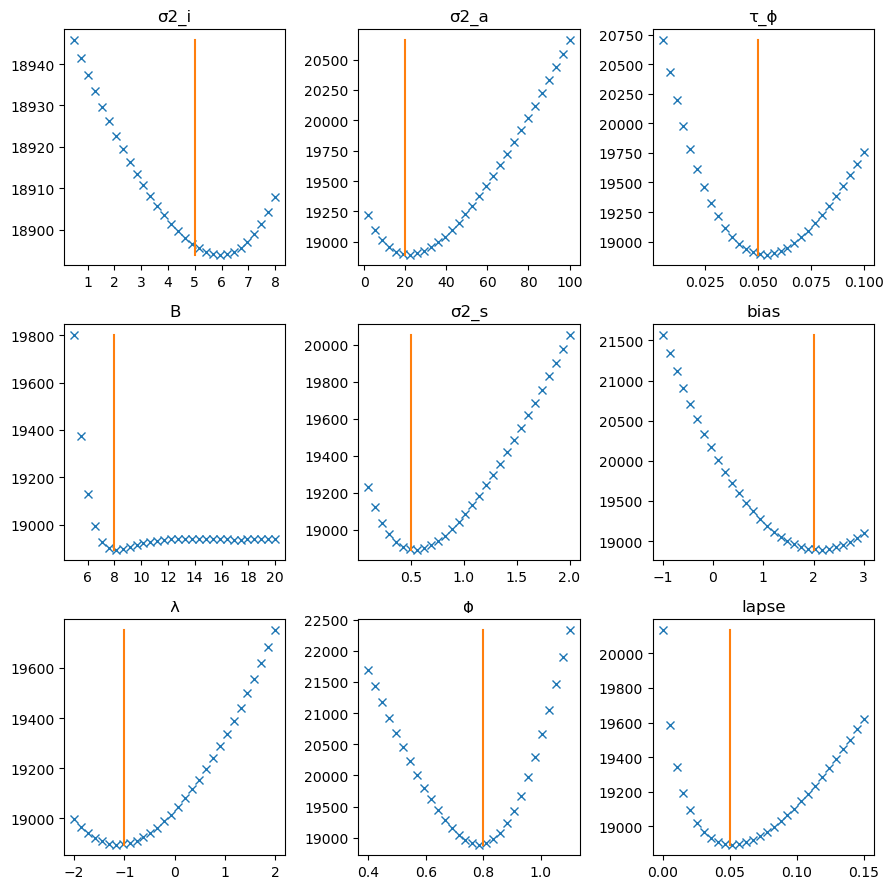

In [38]:
using PyPlot

num_rows, num_cols = 3,3
fig, ax = subplots(num_rows, num_cols, figsize=(9,9))
name = ["σ2_i", "B", "λ", "σ2_a", "σ2_s", "ϕ", "τ_ϕ", "bias", "lapse"]

for i in 1:9
                  
    ax[i].plot(αs[i], LL_scan[i], "x")
    ax[i].set_title(name[i])
    ax[i].plot(x_generative[i]*ones(100), range(minimum(LL_scan[i]), stop=maximum(LL_scan[i]), length=100))
    
    if i == 4
        ax[i].set_xticks(0:20:100)
    elseif i == 1
        ax[i].set_xticks(1:1:8)
    elseif i == 2
        ax[i].set_xticks(6:2:20)
    elseif i == 5
        ax[i].set_xticks(0.5:0.5:2)
    end
    
end

tight_layout() 

## Fit for 60K trials

More or less same as for 20K, but fits are better

In [34]:
output = map(rng-> fit_x0(rng, fit, x0, lb, ub, data_60K), 1:3);

Fminbox
-------
Initial mu = 0.0795041

Fminbox iteration 1
-------------------
Calling inner optimizer with mu = 0.0795041

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     5.756744e+04     7.380181e+04
 * Current step size: 1.0
 * time: 9.512901306152344e-5
 * g(x): [-141.10179952454422, -138.7546889442505, -2460.750432959682, -311.54439300739654, -541.5267372864881, -3663.4590444409064, 2928.0824060555965, 2202.5655288302214, -73801.811970432]
 * ~inv(H): [1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0]
 * x: [7.081000369861408, 15.0, -1.8729303166393252, 1.581856678112148, 4.886128300795011, 0.25316184259024316, 0.9521567581365553, 4.999046588986136, 0.25

    50     1.891694e+04     3.601650e+02
 * Current step size: 0.5
 * time: 3746.6796300411224
 * g(x): [-0.8170642154360211, -0.6996107954082819, -4.619757969757883, -22.211465016370525, -26.71269694703794, 137.98707805410788, -360.16495504096076, -5.749049137226443, 42.34548574350334]
 * ~inv(H): [4.508962645825321 -0.6992017194652775 0.016497523806290076 -0.01192533070639236 -0.021765193017793772 0.008258446185689269 -0.0012714403782197112 0.059455014910958615 -0.0004852065241949346; -0.6992017194652784 0.4028063021277146 0.0050908278116562344 0.002005922874522879 -0.014182713078989651 -0.002517516862581942 0.0001541454648647726 -0.0169208260936827 0.0003954411068779402; 0.016497523806290104 0.00509082781165629 0.00371529606363218 -0.00011287461667999115 -0.0009780277969111265 1.9604972805356503e-5 8.505728247690749e-6 0.0028369115091632525 9.87370565869177e-6; -0.011925330706392262 0.0020059228745228797 -0.00011287461668004688 0.00011690627337898298 3.167017466923304e-5 -2.39556696

    90     1.890853e+04     6.736935e+01
 * Current step size: 1.0
 * time: 6506.274564027786
 * g(x): [0.20944360227291087, 0.1261402251003186, -0.6012417501013877, -1.0238081640408203, 1.303055568903923, -7.0201270143656815, 67.36935068935047, 0.407020770935312, -8.30653564343802]
 * ~inv(H): [7.6716777299414 -3.1313201506350548 -0.0268658403217442 0.31825092880696026 -0.013361986860848718 0.008354288192989478 -0.004504833530350879 0.14779258562675815 0.00012239484748609796; -3.131320150635059 7.536332459723497 0.01791337435372222 0.25481946778662273 -0.2639606395316018 -0.018148109674010062 -5.7308068951412126e-5 -0.09373352860543697 -0.0005485929397744369; -0.026865840321744154 0.01791337435372222 0.006488804456265842 0.004720059066305193 -0.0009793308324731742 0.0006281366798651367 0.0001646226390094628 0.0025454864255777436 -1.4925391174937601e-5; 0.31825092880696026 0.2548194677866224 0.004720059066305142 0.14886433045758402 -0.04914339424424146 0.001928636241165964 0.0010602430

optimization complete. converged: true 

Fminbox
-------
Initial mu = 0.823619

Fminbox iteration 1
-------------------
Calling inner optimizer with mu = 0.823619

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     4.057331e+04     5.320728e+03
 * Current step size: 1.0
 * time: 9.989738464355469e-5
 * g(x): [0.12305451696830771, 23.841014590190532, -203.13484525628604, 1.3259424208769406, 6.218068814349296, -5320.728256358091, 2736.576204118267, -587.2021775771425, 1923.692975694227]
 * ~inv(H): [1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0]
 * x: [11.00389237319773, 15.0, -2.8974356934668744, 163.8676270917991, 5.013711485175227, 0.6712263494997204, 0.52594

    50     1.887193e+04     3.100067e+02
 * Current step size: 1.0
 * time: 3903.481726884842
 * g(x): [-0.4564626699380392, 0.48518220933708844, 1.5833529494727394, -0.26551435012853714, -10.084358452845004, 100.36446583899702, -310.00668618959156, -7.036159339531989, -19.76899259460054]
 * ~inv(H): [1.9776612676712824 0.38892877496280986 0.06422180311496554 0.019269836489382297 0.0024558345312048514 0.007695667205105389 0.0002895042062114714 0.05546670727766577 -0.004059347526956762; 0.38892877496280986 0.1593359524611768 0.036354429665640654 0.3006945992694128 -0.00028825474278931784 -0.0006514691017179448 -0.0007196168436427803 0.02004715966453252 -0.00014455328702258732; 0.06422180311496553 0.03635442966564071 0.02205004622666858 0.050161212714691164 -0.003395735951216377 -0.0001709608530170852 1.3206408459190775e-5 0.005648307603481255 8.421567832289539e-5; 0.019269836489382075 0.30069459926941283 0.050161212714691164 4.072097232414405 -0.08799832025097437 -0.028203479366371687 -

Fminbox iteration 3
-------------------
Calling inner optimizer with mu = 8.23619e-7

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     1.888803e+04     3.371653e+00
 * Current step size: 1.0
 * time: 0.00010800361633300781
 * g(x): [-0.018641935805117225, 0.03369999810853143, -0.02678612146575994, 0.0015270556873892658, -0.21162058694159694, 0.660160137477647, -3.3716530625093335, -0.0009903638409535559, -3.273553934453737]
 * ~inv(H): [1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0]
 * x: [7.090841795919823, 8.182654225197123, -1.071864805927567, 19.53037953765803, 0.5175761103940032, 0.780996670737417, 0.04598137755631674, 2.071109772303946, 0.0454365554230

    40     1.913437e+04     3.488141e+03
 * Current step size: 0.125
 * time: 2642.182315826416
 * g(x): [-5.6646358993626365, 58.418320967896115, -87.03294200096444, -1.5382512565866806, -120.79412815894597, 1102.3542745039767, 650.4878181494663, 20.282506778376543, -3488.1412570033135]
 * ~inv(H): [0.0031479383643092185 -0.0008903058130414921 -0.0005681297892368248 -0.015842104257231995 3.2326088301086517e-6 1.850525502896258e-6 6.493622125639359e-6 -0.00023461503106423024 4.680072798563784e-8; -0.0008903058130414919 0.07179828624599881 -0.005883960879378239 1.148181088846634 0.00037416917927385286 0.00014863074208076987 -0.00022184253276981322 0.0005998342194559539 -7.579016447883746e-6; -0.0005681297892368256 -0.005883960879378218 0.003519682993393624 -0.20184290412882186 -6.658377681744928e-5 -3.778217995960704e-5 1.4716863747439549e-5 -0.00030458604416157297 1.0112198258727592e-6; -0.015842104257231843 1.1481810888466335 -0.20184290412882214 29.157571335344315 0.00296153511190556

    80     1.888607e+04     1.687610e+02
 * Current step size: 1.0
 * time: 5718.091520786285
 * g(x): [0.5278950665845726, -0.21046574051931521, -2.1966441633012446, 0.2998687837727932, 2.5069912757299675, -33.83728082088021, 168.7609847328288, 3.2450913815334794, -22.67273741760577]
 * ~inv(H): [1.2753145672587687 0.04956965159904776 0.05210123734764695 -0.9086076388089777 0.011560918462781962 0.012568021918377742 0.0018180738011604409 0.04030743265496413 -0.004910727632307672; 0.04956965159904768 0.13942574613892098 0.024292025251127513 0.3240211109407469 0.0050758932978612874 -0.0032748064956578766 -0.001313664486267427 0.018822880351172473 0.0019506336858500198; 0.05210123734764687 0.024292025251127492 0.014944988199366847 0.055008292039245774 -0.0025355072303460575 -0.0002860347750168042 -6.43803845503933e-5 0.005818258277451389 0.0001761105463933649; -0.9086076388089777 0.32402111094074704 0.05500829203924584 6.658808130583668 -0.1566938016745287 -0.03242883466979728 -0.00641649

Fminbox iteration 3
-------------------
Calling inner optimizer with mu = 1.92221e-7

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     1.888803e+04     6.323345e-01
 * Current step size: 1.0
 * time: 0.00011086463928222656
 * g(x): [0.0019726515484725766, 0.05760966676300899, 0.006743215421841043, 0.00353152043000983, 0.13205531419576705, 0.6323344847399248, 0.1159557842655575, -0.04728601705640407, -0.18345616138447168]
 * ~inv(H): [1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0]
 * x: [7.142636073374371, 8.198058807612595, -1.0680745560903335, 19.487184892173484, 0.5193577369205951, 0.7815878689001655, 0.046009506162779594, 2.0742974125178897, 0.04536853033

In [35]:
traces_60K = map(y-> hcat(map(x-> x.metadata["x"], y[2].trace)...), output)

3-element Array{Array{Float64,2},1}:
 [7.081000369861408 7.0820768911590495 … 3.1673529554766118 3.1673529426112093; 15.0 15.001058614265016 … 27.911215714269247 27.91121562554202; … ; 4.999046588986136 4.98224234758576 … 2.255414657464257 2.255414508189249; 0.25166218303197185 0.8147253236755265 … 0.05138356414297567 0.05137894472617461]   
 [11.00389237319773 11.003884862546059 … 7.090841875135999 7.090842442280811; 15.0 14.998544859949329 … 8.182654051878133 8.182653015722796; … ; -0.8413043188939673 -0.8054643422352061 … 2.071109612864282 2.0711090850202525; 0.54015152302257 0.42273862167404536 … 0.045447902258920175 0.04544868336542406] 
 [24.350952149875845 24.350913552758016 … 7.142635880727269 7.142635844933809; 15.0 15.000038085094914 … 8.198054047632505 8.198053925035762; … ; -4.9574203939948465 -4.957268298190325 … 2.074301434854558 2.0743016525095195; 0.9746379934512355 0.7802734442962866 … 0.04537633807334806 0.045369001205717886]

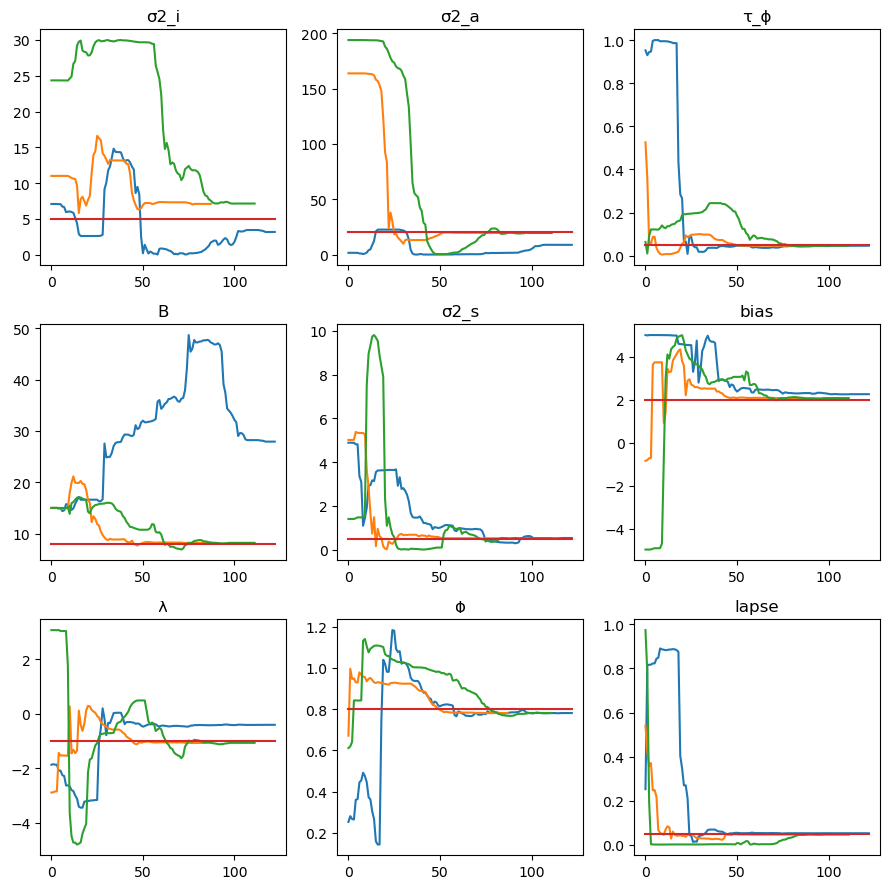

In [36]:
using PyPlot

num_rows, num_cols = 3,3
fig, ax = subplots(num_rows, num_cols, figsize=(9,9))
name = ["σ2_i", "B", "λ", "σ2_a", "σ2_s", "ϕ", "τ_ϕ", "bias", "lapse"]

for i in 1:9
                  
    map(x-> ax[i].plot(x[i,:]), traces_60K)
    ax[i].plot(collect(Flatten.flatten(θ_generative))[i] * ones(maximum(length.(map(x-> x[i,:], traces_60K)))))
    ax[i].set_title(name[i])
    
end

tight_layout() 

In [37]:
models_60K = map(y-> y[1], output)

3-element Array{choiceDDM{θchoice{θz{Float64},Float64},Array{choicedata{pulse_input_DDM.choiceinputs{pulse_input_DDM.clicks,pulse_input_DDM.binned_clicks}},1}},1}:
 choiceDDM{θchoice{θz{Float64},Float64},Array{choicedata{pulse_input_DDM.choiceinputs{pulse_input_DDM.clicks,pulse_input_DDM.binned_clicks}},1}}
  θ: θchoice{θz{Float64},Float64}
  data: Array{choicedata{pulse_input_DDM.choiceinputs{pulse_input_DDM.clicks,pulse_input_DDM.binned_clicks}}}((60000,))

 choiceDDM{θchoice{θz{Float64},Float64},Array{choicedata{pulse_input_DDM.choiceinputs{pulse_input_DDM.clicks,pulse_input_DDM.binned_clicks}},1}}
  θ: θchoice{θz{Float64},Float64}
  data: Array{choicedata{pulse_input_DDM.choiceinputs{pulse_input_DDM.clicks,pulse_input_DDM.binned_clicks}}}((60000,))

 choiceDDM{θchoice{θz{Float64},Float64},Array{choicedata{pulse_input_DDM.choiceinputs{pulse_input_DDM.clicks,pulse_input_DDM.binned_clicks}},1}}
  θ: θchoice{θz{Float64},Float64}
  data: Array{choicedata{pulse_input_DDM.choiceinputs{pul

In [39]:
H_60K = map(x-> Hessian(x), models_60K);

Notice one negative eigenvalue for the first model. It's a small negative value. This is not uncommon. Later, I will show that the optimization stopped at a saddle point.

In [40]:
eigvals.(H_60K)

3-element Array{Array{Float64,1},1}:
 [-0.0042570934063294145, 0.07335627096639982, 0.22635458133643133, 57.09712435648986, 117.7955345662742, 795.5615704839755, 2152.234936739193, 218403.4729625005, 1.5535607224691794e6]
 [0.07117987896933757, 0.1805653013105409, 4.816954824706602, 64.29102289973841, 163.51660231659585, 1341.4992437780302, 2332.7568090800974, 227350.7587300997, 1.5560163293812787e6]   
 [0.07115903903187931, 0.1799971693347617, 4.788676804971517, 64.43995311402908, 162.7346635053735, 1336.6807395202861, 2338.288958484701, 227319.6858807229, 1.550866457796186e6]      

In [41]:
x_fit_60K = collect.(Flatten.flatten.(models_60K))

3-element Array{Array{Float64,1},1}:
 [3.1673529426112093, 27.91121562554202, -0.4060071639570192, 8.775769673768469, 0.5291020335362607, 0.7811037877478852, 0.04597031338531456, 2.255414508189249, 0.05137894472617461]
 [7.090842442280811, 8.182653015722796, -1.0718629967302624, 19.53037901228334, 0.5175803191009517, 0.7809977078285435, 0.04598166987179244, 2.0711090850202525, 0.04544868336542406]
 [7.142635844933809, 8.198053925035762, -1.068075331235247, 19.487184569030404, 0.519345649570371, 0.7815332980453897, 0.04599883062967689, 2.0743016525095195, 0.045369001205717886]

In [42]:
CIs_2 = map(H -> 2 * sqrt.(diag(inv(H))), H_60K[2:3])

2-element Array{Array{Float64,1},1}:
 [4.751916223519948, 1.0730008394724138, 0.370524837894387, 7.435874492110823, 0.23953877663117995, 0.049146023742019276, 0.01034474373644427, 0.2202781299622422, 0.011062759006538858] 
 [4.756888633229372, 1.079246894644587, 0.37027969253261805, 7.437932960479954, 0.23948670164995872, 0.04907753482498146, 0.010353998585388257, 0.2205540202787435, 0.011616080440395915]

Notice that the solution is closer to the generative solution, and the confidence bounds are smaller

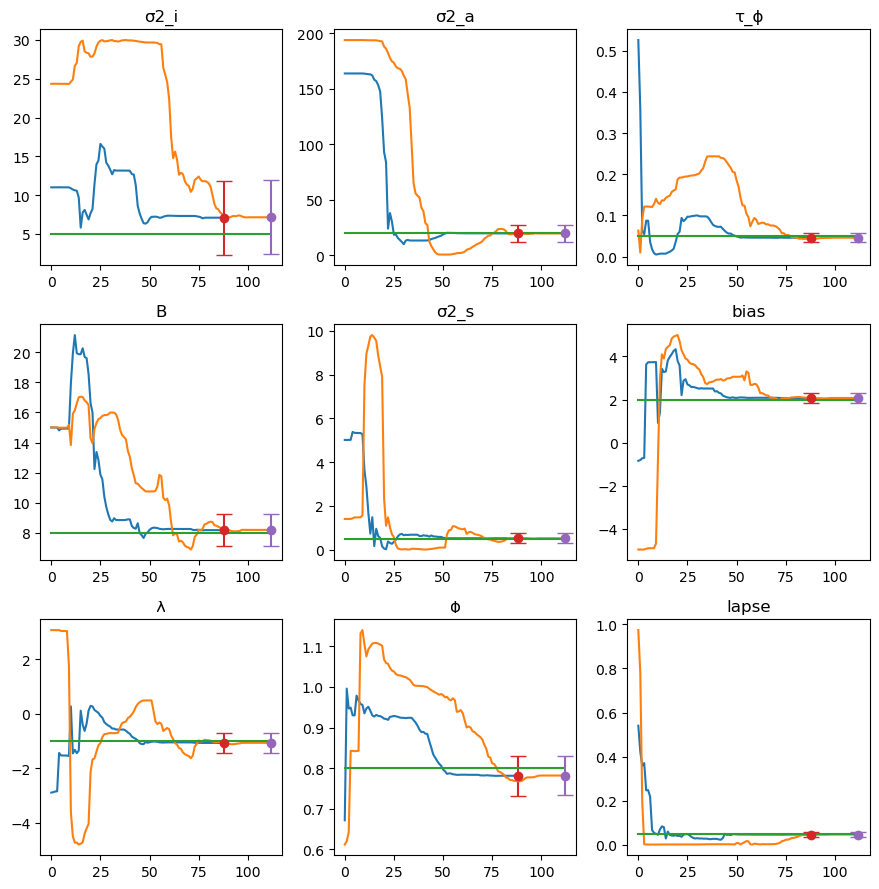

In [183]:
using PyPlot

num_rows, num_cols = 3,3
fig, ax = subplots(num_rows, num_cols, figsize=(9,9))
name = ["σ2_i", "B", "λ", "σ2_a", "σ2_s", "ϕ", "τ_ϕ", "bias", "lapse"]

for i in 1:9
                  
    map(x-> ax[i].plot(x[i,:]), traces_60K[2:3])
    ax[i].plot(collect(Flatten.flatten(θ_generative))[i] * ones(maximum(length.(map(x-> x[i,:], traces_60K[2:3])))))
    ax[i].set_title(name[i])
    
    ax[i].errorbar(size(traces_60K[2], 2), x_fit_60K[2][i], yerr=CIs_2[1][i], fmt="o",
        capsize=6)
    ax[i].errorbar(size(traces_60K[3], 2), x_fit_60K[3][i], yerr=CIs_2[2][i], fmt="o",
        capsize=6)
end

tight_layout() 

In [44]:
CIs_60K = map((x,H) -> hcat(collect(Flatten.flatten(x.θ)) - 2 * sqrt.(diag(inv(H))), 
    collect(Flatten.flatten(x.θ)),
    collect(Flatten.flatten(x.θ)) + 2 * sqrt.(diag(inv(H)))), models_60K[2:3], H_60K[2:3]);

In [45]:
map(i-> all((CIs_60K[i][:,1] .< collect(Flatten.flatten(θ_generative))) .& 
        (CIs_60K[i][:,3] .> collect(Flatten.flatten(θ_generative)))), 1:2)

2-element Array{Bool,1}:
 1
 1

## Look at LL landscape along the negative eigenvalues

This will give us a clue as to what's going on. 

In [69]:
αs = 20e0 *collect(-0.2:0.01:0.2)
xs_neural = map(y-> x_fit_60K[1] + y * eigvecs(H_60K[1])[:,1], αs);

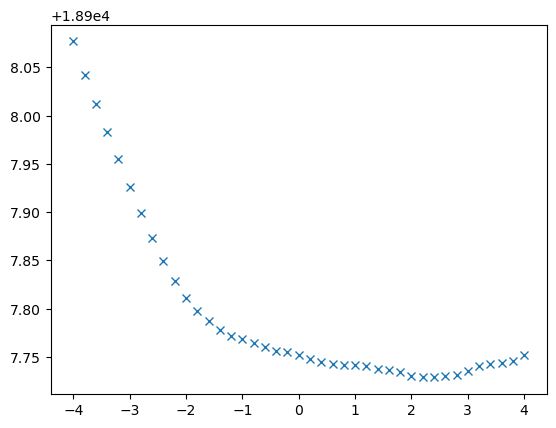

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fa789e94668>

In [71]:
LL_steps_neural = map(y-> (!any((y .< lb) .| (y .> ub)) ? ℓℓ(y, n, data_60K) : -Inf), xs_neural);
finite_LL_steps_neural = filter(isfinite, LL_steps_neural);
finite_αs = αs[isfinite.(LL_steps_neural)];
plot(αs, LL_steps_neural, "x")

We can see that the LL can actually get smaller, so we should reset the tolerances, and/or re-initialize the optimization. I'm going to step along that eigenvector to the value that gives me the min LL

In [72]:
x_restart = x_fit_60K[1] + αs[argmin(LL_steps_neural)] * eigvecs(H_60K[1])[:,1]

9-element Array{Float64,1}:
  3.109783334955107   
 26.020942805417807   
 -0.4059691366600157  
  9.89976542420455    
  0.5428041990269344  
  0.7808408773299687  
  0.045958448850258966
  2.255043683430925   
  0.051413826541096184

## Restart fits

In [ ]:
model_restart = optimize(data_60K, choiceoptions(fit=fit, lb=lb, ub=ub); 
    x0=x_restart, f_tol=1e-15, x_tol=1e-12, g_tol=1e-4, extended_trace=true, show_trace=true)[1];

Fminbox
-------
Initial mu = 0.00223499

Fminbox iteration 1
-------------------
Calling inner optimizer with mu = 0.00223499

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     1.890768e+04     7.387622e+01
 * Current step size: 1.0
 * time: 4.00543212890625e-5
 * g(x): [-0.10015108492501382, -0.07638127567538666, -0.08473774494048976, -0.09305128996941353, -3.403112706254361, 14.641906402083663, -73.87622320408806, -0.005142890611165027, -26.28907498381092]
 * ~inv(H): [1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0]
 * x: [3.109783334955107, 26.020942805417807, -0.4059691366600157, 9.89976542420455, 0.5428041990269344, 0.7808408773299687, 0.04595844885025896

    50     1.890768e+04     5.047718e-03
 * Current step size: 0.42345286789315245
 * time: 5244.08952999115
 * g(x): [-1.8697984966061214e-7, 2.6712310440123855e-5, -2.0128382720042867e-5, 7.97463007658661e-7, 0.00037909300828273653, -0.000830035694507244, 0.005047717590103654, 2.1053648833405233e-5, 0.002071354586995172]
 * ~inv(H): [3.6635596416266605 -0.23703010943185743 -0.06693075225318204 2.172623437213285 -0.017809640476001386 -0.02635250912507286 -0.011004636202040967 0.11743831199488533 -0.0005420442708472554; -0.23703010943185787 0.5212347626900591 0.004148841471133228 -0.5315176101343944 0.010235246427353538 0.004387831114123138 0.0008643378670470567 0.0019581372510602407 -0.00014696272600040519; -0.06693075225318204 0.004148841471133277 0.00714960267059667 -0.06250870513239407 0.0005513176459135008 0.0007747311757934262 0.00027950642275149614 0.0002760426763692156 -4.7867153726817604e-6; 2.1726234372132804 -0.5315176101343939 -0.06250870513239416 6.10887302053141 -0.055152

In [78]:
model_restart

choiceDDM{θchoice{θz{Float64},Float64},Array{choicedata{pulse_input_DDM.choiceinputs{pulse_input_DDM.clicks,pulse_input_DDM.binned_clicks}},1}}
  θ: θchoice{θz{Float64},Float64}
  data: Array{choicedata{pulse_input_DDM.choiceinputs{pulse_input_DDM.clicks,pulse_input_DDM.binned_clicks}}}((60000,))


In [ ]:
H_restart = Hessian(model_restart);

In [77]:
eigvals(H_restart)

9-element Array{Float64,1}:
     -0.00364541597050126 
      0.07030043957664718 
      0.21210575348442096 
     55.88571165267905    
    118.0169829839933     
    809.2878967155236     
   2147.5570657345747     
 218574.08166558758       
      1.5412981808142504e6

## Restart again

In [81]:
x_restart

9-element Array{Float64,1}:
  3.109783334955107   
 26.020942805417807   
 -0.4059691366600157  
  9.89976542420455    
  0.5428041990269344  
  0.7808408773299687  
  0.045958448850258966
  2.255043683430925   
  0.051413826541096184

Moving along that eigenvector didn't get the job done. Instead, I'm going to move to a much smaller value of the bound. The LL can get very flat for large bound values, so let's see if this works.

In [82]:
x_restart[2] = 8.

8.0

In [83]:
model_restart_2 = optimize(data_60K, choiceoptions(fit=fit, lb=lb, ub=ub); 
    x0=x_restart, f_tol=1e-15, x_tol=1e-12, g_tol=1e-4, extended_trace=true, show_trace=true)[1];

Fminbox
-------
Initial mu = 0.399123

Fminbox iteration 1
-------------------
Calling inner optimizer with mu = 0.399123

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     1.899536e+04     1.348644e+04
 * Current step size: 1.0
 * time: 6.699562072753906e-5
 * g(x): [-28.826506560478595, -2.9039081891140883, 66.5860915221884, -15.74513403777807, -703.5787653636904, 2600.063633317108, -13486.435480927756, -57.749656716918466, -4261.076957192983]
 * ~inv(H): [1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0]
 * x: [3.109783334955107, 8.0, -0.4059691366600157, 9.89976542420455, 0.5428041990269344, 0.7808408773299687, 0.045958448850258966, 2.255043683430925, 0.0514


Exiting inner optimizer with x = [7.210611694347384, 8.222235405284579, -1.0616607613376943, 19.54263412852271, 0.5188883467183915, 0.7822044753492112, 0.046046296158710164, 2.077874838398186, 0.04532408354461708]
Current distance to box: 0.0410463
Decreasing barrier term μ.

Fminbox iteration 2
-------------------
Calling inner optimizer with mu = 0.000399123

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     1.888803e+04     9.294605e+00
 * Current step size: 1.0
 * time: 6.890296936035156e-5
 * g(x): [0.03779754629214058, 0.05968113817573228, 0.0354651457136764, 0.018187705080883434, 0.7259131210988343, -0.44367987895982725, 9.2946050918089, -0.0801642028593744, 8.378844549297884]
 * ~inv(H): [1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 


Exiting inner optimizer with x = [7.092506240301523, 8.18204665262904, -1.0720534726827207, 19.47843932535736, 0.5190134643104822, 0.78107842873694, 0.045980202487734864, 2.071514624830409, 0.045445720961397235]
Current distance to box: 0.0409802
Decreasing barrier term μ.

Fminbox iteration 3
-------------------
Calling inner optimizer with mu = 3.99123e-7

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     1.888803e+04     3.459039e-01
 * Current step size: 1.0
 * time: 7.510185241699219e-5
 * g(x): [-0.00041996720897732946, -0.0019639063291282247, 0.05342779033600289, 0.0051673726242233336, 0.14573944322116608, -0.08059358410020864, 0.2716797088294516, -0.06730743703730199, 0.3459038643465497]
 * ~inv(H): [1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0; 0.0 0.0 0.0 

It does

## Different generative parameters

Just to see that there was nothing special about those parameters

In [130]:
θ_generative_2 = θchoice(θz=θz(σ2_i = 1., B = 15., λ = -0.5, σ2_a = 0., σ2_s = 0.,
    ϕ = 0.9, τ_ϕ = 0.02), bias=1., lapse=0.05);

In [131]:
x_generative_2 = collect(Flatten.flatten(θ_generative_2));

In [138]:
_, data_20K_2 = synthetic_data(n ;θ=θ_generative_2, ntrials=20_000, rng=1, dt=1e-2);

In [ ]:
model = choiceDDM(θ=θ_generative_2, data=data_20K_2, n=n)

In [139]:
αs = [range(0.1,stop=5,length=30),
    range(10,stop=20,length=30),
    range(-2,stop=2.,length=30),
    range(0,stop=50,length=30),
    range(0,stop=2.,length=30),
    range(0.5,stop=1.1,length=30),
    range(0.005,stop=0.05,length=30),
    range(-2.,stop=2,length=30),
    range(0.0,stop=0.15,length=30)];

In [140]:
LL_scan_2 = map(i-> map(x-> ℓℓ(vcat(x_generative_2[1:i-1], x, x_generative_2[i+1:end]), model), αs[i]), 1:9);

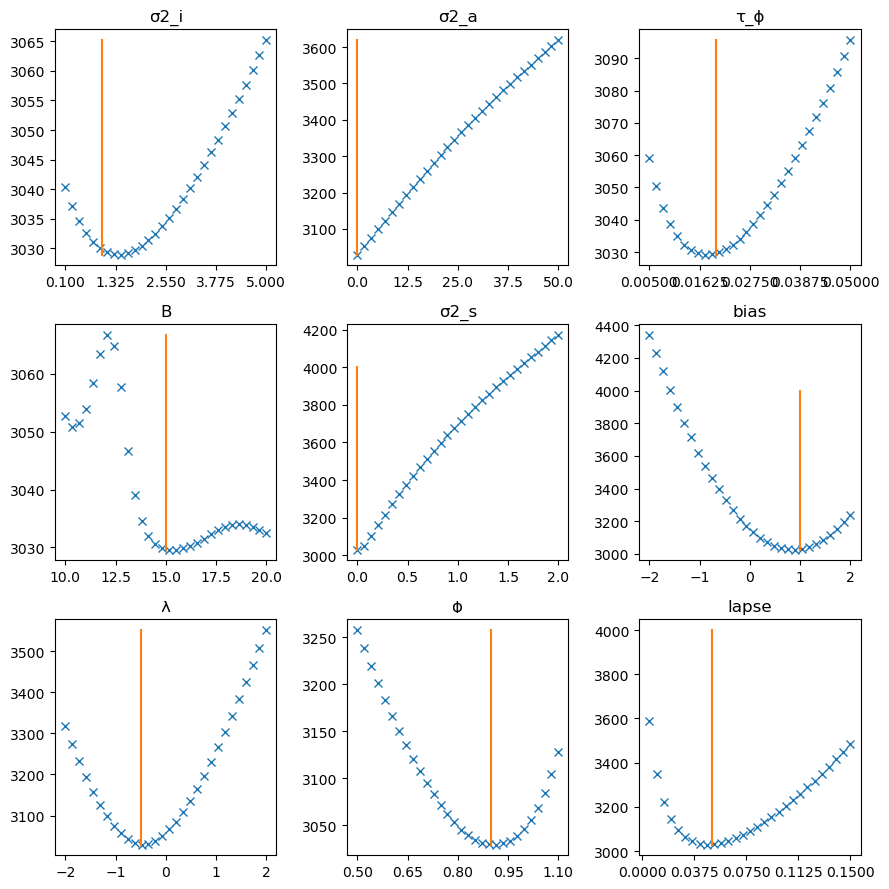

In [155]:
# FP

num_rows, num_cols = 3,3
fig, ax = subplots(num_rows, num_cols, figsize=(9,9))
name = ["σ2_i", "B", "λ", "σ2_a", "σ2_s", "ϕ", "τ_ϕ", "bias", "lapse"]

for i in 1:9
                  
    ax[i].plot(αs[i], LL_scan_2[i], "x")
    ax[i].set_title(name[i])
    ax[i].plot(x_generative_2[i]*ones(100), range(minimum(LL_scan_2[i]), 
            stop=minimum([maximum(LL_scan_2[i]), 4e3]), length=100))
    
    ax[i].set_xticks(range(minimum(αs[i]), stop=maximum(αs[i]), length=5))
    
end

tight_layout() 

In [142]:
loglikelihood(model)

-3029.746318664517

## Fit second set of generative data

In [143]:
output = map(rng-> fit_x0(rng, fit, x0, lb, ub, data_20K_2), 1:2);

Fminbox
-------
Initial mu = 0.029615

Fminbox iteration 1
-------------------
Calling inner optimizer with mu = 0.029615

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     2.050058e+04     2.747873e+04
 * Current step size: 1.0
 * time: 6.103515625e-5
 * g(x): [-54.05064927816736, -51.565242340370624, -915.5657047366008, -115.1681096353471, -203.64062375341726, -1368.9024076930002, 1091.9006080979398, 825.7787592460066, -27478.727767535678]
 * ~inv(H): [1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0]
 * x: [7.081000369861408, 15.0, -1.8729303166393252, 1.581856678112148, 4.886128300795011, 0.25316184259024316, 0.9521567581365553, 4.999046588986136, 0.25166218

    50     3.122022e+03     7.791031e+02
 * Current step size: 0.015625
 * time: 1213.749370098114
 * g(x): [20.576189438524565, 6.517375392195035, -26.29720727807151, 8.132970625657567, -284.3241219384003, 2.2423401848835294, -551.6163476025027, 52.75107785557732, 779.103140648455]
 * ~inv(H): [-0.0011845370010976001 -0.023008388380527572 0.0005914465433573038 -0.026625775714729488 1.5557321793995557e-6 -0.0005774373611109711 -2.5192358465865808e-5 -0.00221011437183918 -9.502378503628381e-6; -0.023008388380527683 10.945450813741118 0.33536165469733653 9.992750272825214 0.0013556118330884277 0.2561759461952829 0.01712141693117189 1.2604998971716075 0.005750813974037995; 0.0005914465433573038 0.33536165469733653 0.02965201831067305 0.3363635214369867 7.531760743549891e-5 0.00949541701535958 0.0007826335287727665 0.05327157912485661 0.00021843670325760563; -0.026625775714729488 9.992750272825216 0.33636352143698667 11.038868926063099 0.0015763095481756452 0.2600515176337543 0.01731296860

    90     3.023421e+03     1.298758e+00
 * Current step size: 0.47599114968085315
 * time: 2357.55540394783
 * g(x): [0.0014926383352465693, 0.0011565069540884995, -0.008259121660859547, -0.23667262568010017, -1.298757898963828, -0.0363403053835918, 0.4321554686629496, 0.003369728234464939, 0.061585056629607005]
 * ~inv(H): [0.4699675054087481 -0.310004624744888 -0.00933349140237909 0.0005022908134802747 -0.00015407600317492485 0.004125016043534086 -0.00023544803786594503 0.006088748597014431 -0.00012307134658938804; -0.31000462474488794 0.43604582551681725 0.0028510604333285435 -0.0010872044542348698 1.8563631981534567e-5 0.0008644553265569481 -0.00011600128960787256 0.0012857326486497207 -1.4738045350707622e-6; -0.009333491402379013 0.002851060433328572 0.004842780781406317 -3.98661829688178e-5 -5.0044931774268566e-8 0.00031675185295779325 7.804655050765592e-5 0.0007275098640095558 -3.475324772713506e-6; 0.000502290813480275 -0.0010872044542348702 -3.9866182969483945e-5 7.0978154565

    30     3.023396e+03     8.563295e+02
 * Current step size: 4.296510043916137e-8
 * time: 975.4185571670532
 * g(x): [0.017817089889106366, 0.011476626504735467, -0.014698446516223028, 856.329474166369, 12.741251847221019, 0.005742953570287895, 1.610332027392772, 0.0336695824940573, 0.14939194677918208]
 * ~inv(H): [1.0000001193382173 7.639805630525033e-8 -8.111784454518953e-8 1.2411028976305422e-6 -2.5723818756882118e-5 3.2383270397737524e-7 9.854989073435374e-6 1.924379414252097e-7 1.0953568535321398e-6; 7.639805630525033e-8 1.0000000487092278 -5.092024744654524e-8 4.3583216905599045e-7 -2.314319894233188e-6 1.7220225748536746e-7 6.368884422221296e-6 1.2235223748000054e-7 7.068808810147656e-7; -8.111784454518953e-8 -5.0920247446545246e-8 1.0000000500159694 3.577643494789245e-6 -5.414567501388122e-5 -4.243623619949988e-8 -7.001721430982179e-6 -1.2652218568606226e-7 -7.732269094983042e-7; 1.2411028976305422e-6 4.3583216905598706e-7 3.577643494789245e-6 1.021021119961353e-9 -1.608984


Exiting inner optimizer with x = [2.344534018221047, 13.68268021980376, -0.5313838370524547, 4.046723931030541e-11, 5.211735906568792e-6, 0.8952956270220469, 0.01673041859495674, 0.8734910945130007, 0.04748206088985009]
Current distance to box: 4.04672e-11
Decreasing barrier term μ.

optimization complete. converged: true 

Fminbox
-------
Initial mu = 0.298683

Fminbox iteration 1
-------------------
Calling inner optimizer with mu = 0.298683

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     1.342155e+04     1.900968e+03
 * Current step size: 1.0
 * time: 0.00021004676818847656
 * g(x): [0.21174454073543628, 7.745893211817683, -61.36848986028816, 0.6827664146458593, 4.336861815938303, -1900.9675394658166, 966.6742818829563, -109.90993439685747, 865.7241298349823]
 * ~inv(H): [1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0

    50     3.260320e+03     3.193625e+02
 * Current step size: 1.0
 * time: 1147.080342054367
 * g(x): [0.27057276932753005, 0.31485306494716747, 1.577453179247582, 0.29791165784722845, -15.11078689166481, -165.78346573975168, 2.07694953685547, 4.094438065171036, -319.36247239503757]
 * ~inv(H): [0.5776490503959344 0.04447838163841783 0.1118461041916744 -15.239066291478697 -0.01164865320597453 -0.0005699594266801121 0.008732339543700307 0.03188709734656108 -0.00016409298372811073; 0.04447838163841707 6.307311100819796 0.06897404252171607 -9.950472974011479 0.1185571274831807 2.2964478915789397e-5 -0.022105463138436886 0.3441451771012512 -0.0013052378731759884; 0.11184610419167418 0.0689740425217163 0.06265955214329014 -5.300426701266115 -0.0054924777688555885 -0.00019673902731750216 0.0019773239329697024 0.023581019228163025 2.4023791755117276e-5; -15.239066291478688 -9.950472974011468 -5.300426701266115 732.108245865895 0.47828386287184743 0.026929452810031545 -0.4146360750804298 -3.1

    90     3.222106e+03     1.280380e+01
 * Current step size: 1.7536643562484668e-5
 * time: 2245.1218600273132
 * g(x): [1.7245548411627087, 0.10554536017972135, 0.5055353922853036, 0.7365607982506326, 2.7004180603817654, -6.501342655338546, 9.429475306371025, 0.9470618443030483, 12.803795206116568]
 * ~inv(H): [1.0507040272338664 0.002784542420554778 0.014864878310231635 0.018361368990958978 0.06575731416212377 0.07626127374669686 0.27556857511757366 0.027299482665024966 0.030942862854227954; 0.0027845424205547786 1.000152387696723 0.0008163456660288288 0.0010028547138525613 0.0035884336443282204 0.004635106257547669 0.01513076801614677 0.0014983099336445345 0.0011217343890898047; 0.014864878310231635 0.0008163456660288288 1.0043579301018037 0.005383021048986213 0.019278152706343386 0.022355356026825715 0.08078833640732956 0.008003382178184436 0.009074257458182147; 0.018361368990958974 0.0010028547138525611 0.005383021048986213 1.0065922307992246 0.02357686005853894 0.03223841711962

   130     3.025279e+03     7.883142e+01
 * Current step size: 1.0
 * time: 3233.636867046356
 * g(x): [-78.8314162962966, 0.00895728323680475, 0.022236932247495247, -52.31941805921302, 0.9029213408363992, -3.2269893246169357, -0.37241830161453393, -0.017946014608615557, 0.5555240342181422]
 * ~inv(H): [3.131050433818096e-7 8.974186477607226e-6 -6.142547111784752e-6 3.7869573809066055e-7 -3.3989495968895325e-7 -1.1639525051456031e-5 -8.439177293271426e-7 -7.03099425118204e-6 -3.391972728004049e-8; 8.974186477609151e-6 4.043701992972474 0.022649628444890834 -3.201357916314459e-5 -0.029625252302998763 -0.0017152973868527575 0.0013477907529470506 -0.006157166469422272 0.00011238962733903894; -6.142547112228839e-6 0.022649628444890785 0.0044063116344332225 -7.5965663292564074e-6 -0.0001436618164457835 0.00023810817489281847 8.602768194586766e-5 0.0009099487303837652 6.860471655863832e-6; 3.7869573809060624e-7 -3.201357916317969e-5 -7.596566329482753e-6 5.174377736073443e-7 5.96426232016763

    20     3.023559e+03     5.625595e+03
 * Current step size: 0.03125
 * time: 548.0145859718323
 * g(x): [-1.7403335345104005, 1.1803916970897055, -1.712610723281378, -3.038719036092753, -5625.595042949215, -7.0129075099012885, 72.36031438325573, 2.796418789303858, 16.815977353264085]
 * ~inv(H): [30.75104424646167 -20.833906770671433 11.69460973932379 -9.15714366556788 -0.0027747577172799287 0.2181269668037412 0.09785884967843018 4.691141019688355 0.0056620874450817515; -20.83390677067143 15.54237997511636 -8.08008723822014 6.366877527070788 0.0019450806702532549 -0.11188260927617222 -0.0673821059271972 -3.1705927441092703 -0.00451435961461801; 11.69460973932379 -8.08008723822014 4.907383279297804 -3.5474912673471883 -0.00098738275560463 0.1364544123820972 0.04421269295290413 2.0362539306987513 0.001786687973196538; -9.157143665567878 6.3668775270707885 -3.547491267347189 2.7518285080043334 0.0008269249221864428 -0.06829232008308458 -0.03008049216786668 -1.4236119550052853 -0.001731


Exiting inner optimizer with x = [3.1196875967934696, 11.0891060824323, -0.5353736669706772, 1.1056225122009327e-5, 2.469449431592377e-6, 0.8919464551152444, 0.017081463789953413, 0.866072344179079, 0.04756666536877366]
Current distance to box: 2.46945e-6
Decreasing barrier term μ.

Fminbox iteration 3
-------------------
Calling inner optimizer with mu = 2.98683e-7

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     3.023245e+03     1.144647e+02
 * Current step size: 1.0
 * time: 4.506111145019531e-5
 * g(x): [-0.001198532721089827, -0.0025289973277609814, -0.004495191058327826, 26.45792339445446, 114.46474513099882, 0.034648191808113515, -0.39387437006045234, -0.00444127202585094, 0.0006972043859881596]
 * ~inv(H): [1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0; 0.0


Exiting inner optimizer with x = [3.119688181663574, 11.089119641938508, -0.5353560316075294, 1.6497150341914322e-10, 1.8430590977530392e-10, 0.8916531953180811, 0.017058084843259262, 0.8660626613201284, 0.0475653592334658]
Current distance to box: 1.64972e-10
Decreasing barrier term μ.

optimization complete. converged: true 



In [144]:
traces_20K_2 = map(y-> hcat(map(x-> x.metadata["x"], y[2].trace)...), output)

2-element Array{Array{Float64,2},1}:
 [7.081000369861408 7.081825117317434 … 2.344534018221047 2.344534018221047; 15.0 15.000786823155828 … 13.68268021980376 13.68268021980376; … ; 4.999046588986136 4.986446205086509 … 0.8734910945130007 0.8734910945130007; 0.25166218303197185 0.6709542937426602 … 0.0474820608898501 0.04748206088985009]      
 [11.00389237319773 11.003840677753214 … 3.1196881816635744 3.119688181663574; 15.0 14.998108912790084 … 11.089119641938506 11.089119641938508; … ; -0.8413043188939673 -0.8144708388166095 … 0.8660626613201317 0.8660626613201284; 0.54015152302257 0.32879309288707625 … 0.04756535923345493 0.0475653592334658]

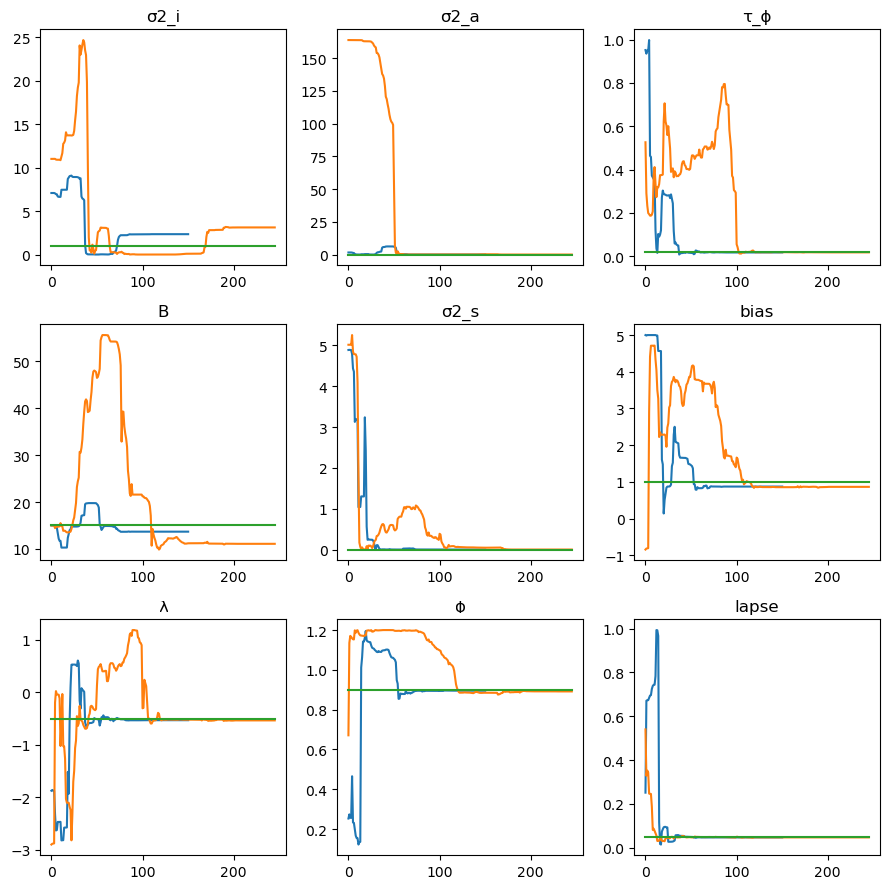

In [145]:
num_rows, num_cols = 3,3
fig, ax = subplots(num_rows, num_cols, figsize=(9,9))
name = ["σ2_i", "B", "λ", "σ2_a", "σ2_s", "ϕ", "τ_ϕ", "bias", "lapse"]

for i in 1:9
                  
    map(x-> ax[i].plot(x[i,:]), traces_20K_2)
    ax[i].plot(collect(Flatten.flatten(θ_generative_2))[i] * ones(maximum(length.(map(x-> x[i,:], traces_20K_2)))))
    ax[i].set_title(name[i])
    
end

tight_layout() 

Fits well again

In [146]:
models_20K_2 = map(y-> y[1], output)
H_20K_2 = map(x-> Hessian(x), models_20K_2);
eigvals.(H_20K_2)

2-element Array{Array{Float64,1},1}:
 [-7.673145875108616e14, 1.0476055012115766, 6.79628884638673, 189.18100188068982, 317.34542972083926, 1704.8711695714585, 67944.49382620805, 184961.6644238769, 274418.78965412977]     
 [-2.0011930609274375e13, -3.026717991715062e11, 1.1707665286781719, 5.5007305159665085, 194.9582547694266, 355.3343733559123, 1842.1295784421159, 185065.51298808673, 228457.6346417521]

Look at the VERY large negative eigenvalues. This is another common problem that will prevent inverting the hessian. As we can see above, the LL when variance values get close to zero looks more concave than convex, which is causing these large negative eigenvalues. 

In [160]:
eigvecs.(H_20K_2)[1][:,1]

9-element Array{Float64,1}:
  1.4305329526276019e-10
  1.5862708748917996e-10
  3.9968124020663473e-10
 -1.0                   
  8.237121801549636e-9  
 -1.1575277006094786e-9 
  9.039572071577921e-9  
 -5.839728968442687e-10 
  4.139179308621246e-9  

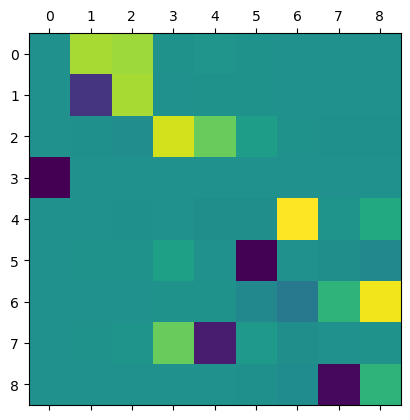

PyObject <matplotlib.image.AxesImage object at 0x7fa7479abe80>

In [318]:
matshow(eigvecs.(H_20K_2)[1])

In [319]:
eigvecs.(H_20K_2)[1][:,7]

9-element Array{Float64,1}:
  0.0035309971553483476
  0.003412351860077551 
  0.014030911268831799 
  6.089024640725442e-9 
  0.9784707982824706   
  0.0024185778659905777
 -0.20156808415860508  
 -0.01488001421388299  
 -0.038948189406349774 

In [156]:
eigvecs.(H_20K_2)[2][:,1:2]

9×2 Array{Float64,2}:
 -1.59837e-9    2.09137e-10
  3.85141e-10  -7.69457e-9 
 -4.94152e-9   -9.98881e-9 
  1.0          -0.000155835
 -0.000155835  -1.0        
  6.98879e-9    2.47361e-7 
 -6.05998e-8   -9.07216e-7 
  6.12562e-9   -4.20162e-8 
 -4.09451e-8    2.8982e-8  

In [157]:
x_fit_20K_2 = collect.(Flatten.flatten.(models_20K_2))

2-element Array{Array{Float64,1},1}:
 [2.344534018221047, 13.68268021980376, -0.5313838370524547, 4.046723931030541e-11, 5.211735906568792e-6, 0.8952956270220469, 0.01673041859495674, 0.8734910945130007, 0.04748206088985009]    
 [3.119688181663574, 11.089119641938508, -0.5353560316075294, 1.6497150341914322e-10, 1.8430590977530392e-10, 0.8916531953180811, 0.017058084843259262, 0.8660626613201284, 0.0475653592334658]

## How to fix the hessian in these cases

The laplace approximation makes a Gaussian assumption about the likelihood surface around the ML solution, which means the LL surface should be a quadratic. Clearly it's not for the large negative eigenvalue in this case. So, I will walk along the LL surface, along that eigenvector, compute the LL, and then make a quadratic approxmation to the surface, as best I can.

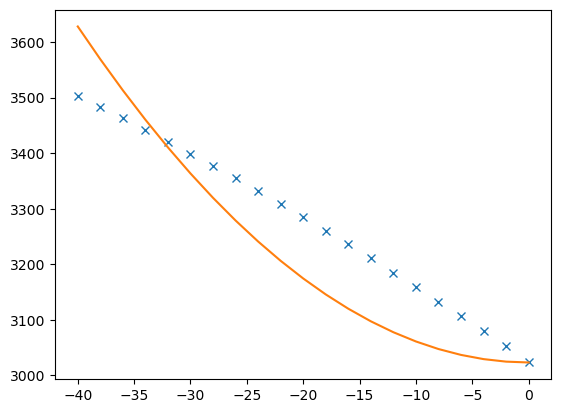

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fa78b002f98>

In [159]:
αs = 20e1 *collect(-0.2:0.01:0.2)
xs_neural = map(y-> x_fit_20K_2[1] + y * eigvecs(H_20K_2[1])[:,1], αs);
LL_steps_neural = map(y-> (!any((y .< lb) .| (y .> ub)) ? ℓℓ(y, n, data_20K_2) : -Inf), xs_neural);
finite_LL_steps_neural = filter(isfinite, LL_steps_neural);
finite_αs = αs[isfinite.(LL_steps_neural)];
β1 = (finite_αs.^2)\(finite_LL_steps_neural .- minimum(finite_LL_steps_neural))
plot(αs, LL_steps_neural, "x")
plot(finite_αs, β1 * finite_αs .^2 .+ minimum(finite_LL_steps_neural))

In [163]:
corrected_H_20K_2 = Vector(undef, 2)

2-element Array{Any,1}:
 #undef
 #undef

In [ ]:
Then, I replace that large negative eigenvalue with that approxmation (times 2, since there's a 0.5 in the second term of thetaylor series approxmiation)

In [164]:
corrected_H_20K_2[1] = eigvecs(H_20K_2[1]) * Diagonal(vcat(2*β1, eigvals(H_20K_2[1])[2:end])) * inv(eigvecs(H_20K_2[1]))

9×9 Array{Float64,2}:
    8.86115       6.66488     …    -2.26218       234.349     
    6.66487       6.94882          -1.62943       183.51      
    5.33865       2.97871         -81.177         282.877     
    1.22725e-5    9.42621e-6        1.64058e-5      0.00108588
  428.865       370.346          -546.808        9668.99      
 -101.492       -70.5373      …  -269.992       -2921.15      
  845.92        611.79           2347.26        22939.3       
   -2.26218      -1.62943         322.723         -96.5897    
  234.349       183.51            -96.5897          1.9213e5  

In [165]:
eigvals(corrected_H_20K_2[1])

9-element Array{Float64,1}:
      0.7559411284210005
      1.0476055012098917
      6.796288846384912 
    189.18100188068564  
    317.34542972083636  
   1704.8711695714583   
  67944.49382620795     
 184961.66442387676     
 274418.78965412977     

In [167]:
CIs_20K_2 = 2 * sqrt.(diag(inv(corrected_H_20K_2[1])))

9-element Array{Float64,1}:
 1.505423292095772    
 1.4624711655132854   
 0.13919290695705688  
 2.3003080982193156   
 0.008637208798129693 
 0.05422362607067624  
 0.0063664658349375305
 0.12411519072209597  
 0.0046412012767613215

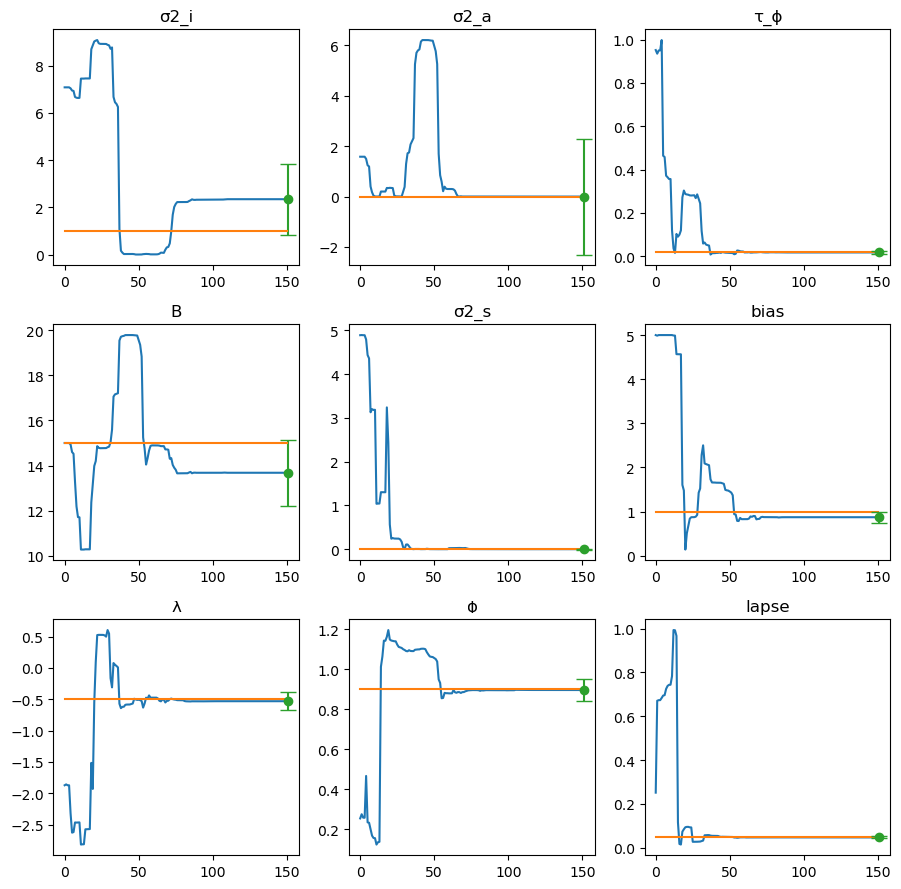

In [181]:
num_rows, num_cols = 3,3
fig, ax = subplots(num_rows, num_cols, figsize=(9,9))
name = ["σ2_i", "B", "λ", "σ2_a", "σ2_s", "ϕ", "τ_ϕ", "bias", "lapse"]

for i in 1:9
                  
    ax[i].plot(traces_20K_2[1][i,:])
    ax[i].plot(collect(Flatten.flatten(θ_generative_2))[i] * ones(maximum(length(traces_20K_2[1][i,:]))))
    ax[i].set_title(name[i])
    
    ax[i].errorbar(size(traces_20K_2[1], 2), x_fit_20K_2[1][i], yerr=CIs_20K_2[i], fmt="o",
        capsize=6)
end

tight_layout() 

In [184]:
bounds_20K_2 = hcat(x_fit_20K_2[1] - 2 * sqrt.(diag(inv(corrected_H_20K_2[1]))), 
    x_fit_20K_2[1],
    x_fit_20K_2[1] + 2 * sqrt.(diag(inv(corrected_H_20K_2[1]))));

In [191]:
(bounds_20K_2[:,1] .< x_generative_2) .& 
        (bounds_20K_2[:,3] .> x_generative_2)

9-element BitArray{1}:
 1
 1
 1
 1
 1
 1
 1
 0
 1

In [189]:
bounds_20K_2

9×3 Array{Float64,2}:
  0.839111    2.34453       3.84996   
 12.2202     13.6827       15.1452    
 -0.670577   -0.531384     -0.392191  
 -2.30031     4.04672e-11   2.30031   
 -0.008632    5.21174e-6    0.00864242
  0.841072    0.895296      0.949519  
  0.010364    0.0167304     0.0230969 
  0.749376    0.873491      0.997606  
  0.0428409   0.0474821     0.0521233 

In [192]:
x_generative_2

9-element Array{Float64,1}:
  1.0 
 15.0 
 -0.5 
  0.0 
  0.0 
  0.9 
  0.02
  1.0 
  0.05